# Quantify **Organelle Interactions** - part 2.2
--------------------
## **OBJECTIVE**
### <input type="checkbox"/> Quantify ***organelle interactions***
In this notebook, the logic for quantifying organelle **interaction composition** (how much of each interaction is present) and **morphology** (overlap site size and shape) is outlined.


---------
## **Organelle Interactions**

### summary of steps

🛠️ **BUILD FUNCTION PROTOTYPE**

- **`1`** - Examine how pair-wise overlappings are made

    - assemble list of pair-wise contacts

    - create overlapping regions between two organelle types

- **`2`** - Determine pair-wise overlappings that are present in triplet-wise overlaps (redundant overlaps)

    - iterate across all other organelle segmentations to find overlaps with the pair-wise overlapping region

    - watershed triplet-wise overlapping regions into pair-wise overlapping regions

- **`3`** - Use process for triplet-wise overlaps to make nth-wise overlaps 

    - assemble list of all possible contacts ranging from pair-wise to n-wise
    
    - iterate across n organelle types and create overlapping regions between them

- **`4`** - Expand on the method for finding redundant overlaps to find n-wise overlaps present in n+1 overlaps

    - iterate across all other organelle segmentations to find overlaps with the n-wise overlapping region

    - watershed n+1-wise overlaping regions into n-wise overlapping regions

- **`5`** - Build the list of measurements we want to include from regionprops and run regionprops

    - assemble list of measurements (morphological properties)

    - create initial regionprops table

- **`6`** - Track which individual organelles are involved in that interaction

    - identify labels involved in each unique interaction

    - correct and add measurements

⚙️ **EXECUTE FUNCTION PROTOTYPE**

- Define `_get_contact_metrics_3D` function
- Run `_get_contact_metrics_3D` function (scaled)
- Compare to finalized `get_contact_metrics_3D` function

## **IMPORTS**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block loads all of the necessary python packages and functions you will need for this notebook.

In [1]:
from pathlib import Path
import os

import napari
from napari.utils.notebook_display import nbscreenshot
from skimage.measure import (regionprops_table)

from infer_subc.core.file_io import (read_czi_image,
                                     import_inferred_organelle,
                                     list_image_files)

from infer_subc.core.img import *
from infer_subc.utils.stats import *
from infer_subc.utils.stats import (_assert_uint16_labels)
from infer_subc.utils.stats_helpers import *

from infer_subc.organelles import * 

%load_ext autoreload
%autoreload 2

## **LOAD AND READ IN IMAGE FOR PROCESSING**
> ###### 📝 **Specifically, this will include the raw image and the outputs from segmentation**

#### &#x1F6D1; &#x270D; **User Input Required:**

In [2]:
## Define the path to the directory that contains the input image folder.
data_root_path = Path(os.path.expanduser("~")) / "Documents/Python Scripts/Infer-subc-2D"

## Specify which subfolder that contains the input data and what the file type is. Ex) ".czi" or ".tiff"
in_data_path = data_root_path / "raw_single"
raw_img_type = ".tiff"

## Specify which subfolder contains the segmentation outputs and their file type
seg_data_path = data_root_path / "out_single"
seg_img_type = ".tiff"

## Specify the name of the output folder where quantification results will be saved
out_data_path = data_root_path / "quant_single"

## Specify which file you'd like to segment from the img_file_list
test_img_n = 0

## Specify the suffixes on the organelle segmentation files (i.e., the stuff following the "-")
org_names = ["lyso", "mito", "golgi", "perox", "ER", "LD"]

## Specify the suffixes on the region segmentation files (i.e., the stuff following the "-")
region_names = ["nuc", "cell"]

## Specify the suffix on the region segmentation file pertaining to the cell mask
mask = "cell"

## Specify the "splitter" that will be used between groupings of organelle names (i.e. lysoXmito)
splitter = "X"

#### &#x1F3C3; **Run code; no user input required**

In [3]:
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

raw_file_list = list_image_files(in_data_path, raw_img_type)
seg_file_list = list_image_files(seg_data_path, seg_img_type)
# pd.set_option('display.max_colwidth', None)
# pd.DataFrame({"Image Name":img_file_list})

In [4]:
raw_img_name = raw_file_list[test_img_n]

raw_img_data, raw_meta_dict = read_czi_image(raw_img_name)

channel_names = raw_meta_dict['name']
img = raw_meta_dict['metadata']['aicsimage']
scale = raw_meta_dict['scale']
channel_axis = raw_meta_dict['channel_axis']

In [5]:
org_segs = [import_inferred_organelle(org, raw_meta_dict, seg_data_path, seg_img_type) for org in org_names]
region_segs = [import_inferred_organelle(reg, raw_meta_dict, seg_data_path, seg_img_type) for reg in region_names]

loaded  inferred 3D `lyso`  from C:\Users\zscoman\Documents\Python Scripts\Infer-subc-2D\out_single 
loaded  inferred 3D `mito`  from C:\Users\zscoman\Documents\Python Scripts\Infer-subc-2D\out_single 
loaded  inferred 3D `golgi`  from C:\Users\zscoman\Documents\Python Scripts\Infer-subc-2D\out_single 
loaded  inferred 3D `perox`  from C:\Users\zscoman\Documents\Python Scripts\Infer-subc-2D\out_single 
loaded  inferred 3D `ER`  from C:\Users\zscoman\Documents\Python Scripts\Infer-subc-2D\out_single 
loaded  inferred 3D `LD`  from C:\Users\zscoman\Documents\Python Scripts\Infer-subc-2D\out_single 
loaded  inferred 3D `nuc`  from C:\Users\zscoman\Documents\Python Scripts\Infer-subc-2D\out_single 
loaded  inferred 3D `cell`  from C:\Users\zscoman\Documents\Python Scripts\Infer-subc-2D\out_single 


In [6]:
organelle_segs = {}                                                     
for idx, name in enumerate(org_names):                                  
    if name == 'ER':                                                    
        organelle_segs[name]=(org_segs[idx]>0).astype(np.uint16)        
    else:                                                       
        organelle_segs[name]=org_segs[idx]                      

In [7]:
mask_img = region_segs[region_names.index("cell")]

-----------------
Here we are defining an **organelle interaction** as any amount of pixel/voxel overlap between two organelles of different types. The overlap region will be know as the **interaction site**. We have implemented a pipeline that identifies two-way, three-way, and higher order contacts as well. This pipeline additionally distinguishes whether a contact is present in a higher order contact or not. Finally, the method for identifying individual contacts in this pipeline enables the use of "declumped" organelle segmentations.

We will utilize similar regionprops measurements as was done to quantify organelle and cell regions morphology.

> ###### 📝 **Since organelle contact sites are smaller than our resolution limit for confocal microscopy, the region of overlap is only an estimation of contacts. It may be helpful to dilate a single organelle (the organelle of interest) before determining the overlap region. This will include any touching, but not overlapping interactions and may improve our ability to detect differences in this subresolution system**

# ***BUILD FUNCTION PROTOTYPE***

## **`1` - Examine how 2-Way overlappings are made**

**aXb**: organelle a overlapping with organelle b (*NOTE: aXb and bXa overlaps are redundant*)

- assemble list of pair-wise contacts

In [8]:
paircomb = itertools.combinations(org_names, 2)
pairs = [splitter.join(cont) for cont in paircomb]
print(enumerate(pairs))

#### &#x1F6D1; &#x270D; **User Input Required:**

In [9]:
# Enter the organelles in the desired pair
orgA = "mito"
orgB = "lyso"

#### &#x1F3C3; **Run code; no user input required**

- create overlapping regions between two organelle types

In [10]:
# Creating desired overlap regions
a = organelle_segs[orgA]        #collects organelle a
b = organelle_segs[orgB]        #collects organelle b
c = (a>0)*(b>0)                 #determines true overlapping area without labels
digit = len(str(np.max(a)))     #finds number of digits in largest valued label of organelle a segmentation
overlap = (b*(10**(digit+1)))+a #assigns unique labels to each overlap
overlap[c==False] = 0           #ensures that locations with no overlap are labeled as 0
overlap = label(overlap)        #simplifies labels

- visualize segmentations 'a' and 'b'

02-Dec-24 14:30:41 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1280x1212+12+46 (frame: 1302x1268+1+1) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1280x1050+12+46 (frame: 1302x1106+1+1) margins: 11, 45, 11, 11 minimum size: 385x491 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=792,1038 maxtrack=0,0)


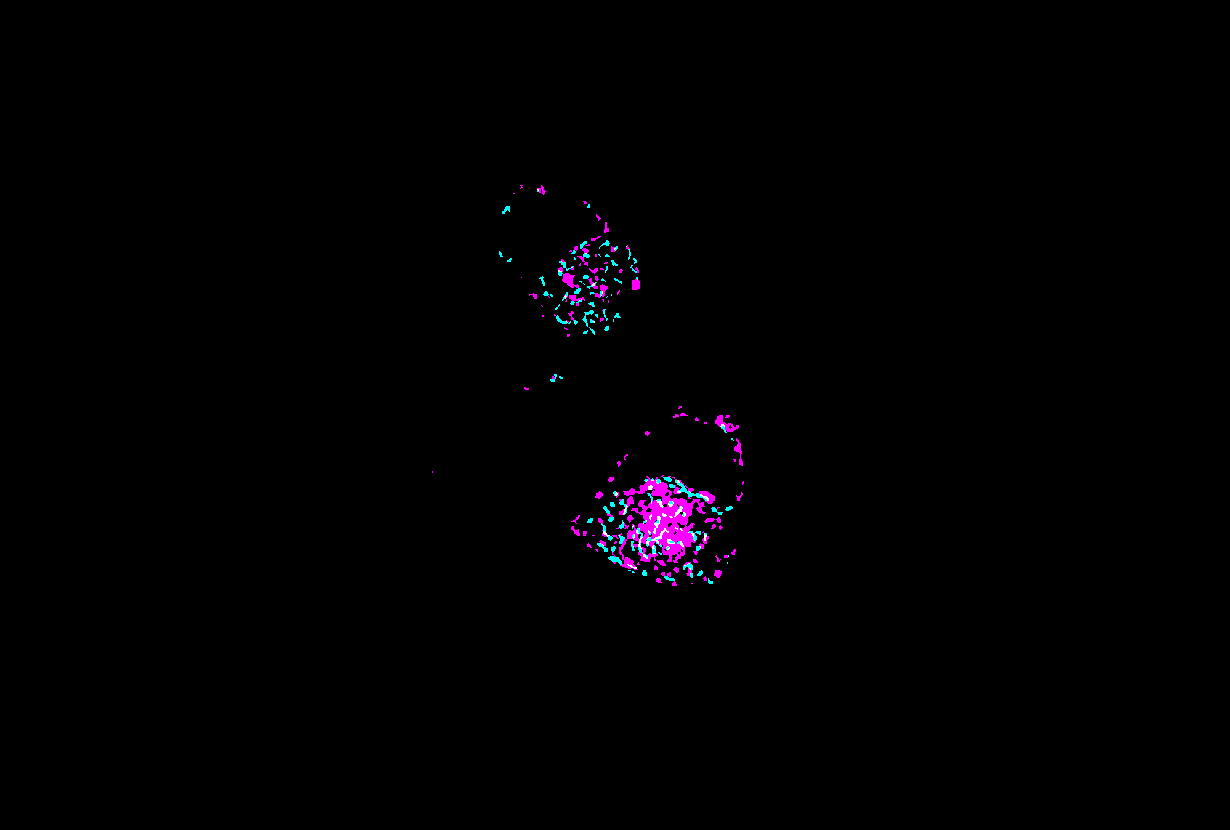

In [11]:
viewer = napari.Viewer()

viewer.add_image(a>0, colormap='cyan', blending ='additive', scale=scale)
viewer.add_image(b>0, colormap='magenta', blending ='additive', scale=scale)
viewer.add_image(overlap>0, blending ='additive', scale=scale)

nbscreenshot(viewer, canvas_only=True)

In [12]:
viewer.close()

## **`2` - Determine 2-Way overlaps that are present in 3-Way overlaps (redundant overlaps)**

- iterate across all other organelle segmentations to find 3rd order overlaps with the 2nd order overlapping region

In [13]:
LOc_NR = overlap.copy()                         #Creates a copy of the overlap for the non-redundant contacts
for org, val in organelle_segs.items():         #Iterates across the organelle segmentations
    if ((org not in [orgA, orgB])               #Proceeds if the organelle is not org A or B,
        and np.any(overlap*val)):               #Proceeds if there is an overlap between the interaction region and the iterated organelle
        digit = len(str(np.max(val)))           #Determines the number of digits in the maximum value of the iterated organelle
        valid = (LOc_NR>0)*(val>0)              #Isolates the area where both the interaction region and the iterated organelle overlap
        HOc = (LOc_NR*(10**(digit)))+val        #Creates new overlaps between the iterated organelle and the interaction region
        HOc[valid.astype(bool)==False]=0        #Ensures all values outside of the higher order interaction are set to 0
        HOc = label(HOc)                        #Relabels the higher order interactions to be less RAM and CPU intensive
        for id in np.unique(overlap[HOc > 0]):   #Iterates across IDs present within the higher order interaction region
            LOc_NR[LOc_NR==id] = 0              #Removes iterated ID that was present in a higher order interaction

- visualize segmentations 'a' and 'b', their interactions, and their interactions present in higher order interactions

c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\napari\components\viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,
c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\napari\components\viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,
c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\napari\components\viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,


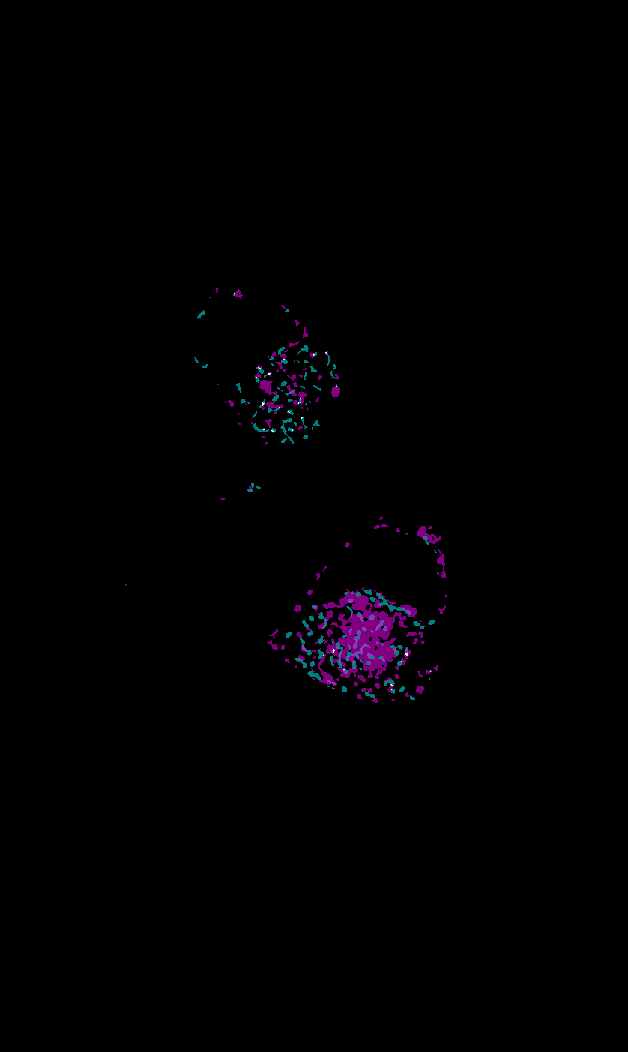

In [14]:
viewer = napari.Viewer()

viewer.add_labels(a>0, color={1:'cyan'}, blending='translucent', opacity=0.5, scale=scale)
viewer.add_labels(b>0, color={1:'magenta'}, blending='translucent', opacity=0.5, scale=scale)
viewer.add_labels(LOc_NR>0, color={1:'white'}, blending='translucent', opacity=1.00, scale=scale)
nbscreenshot(viewer, canvas_only=True)

In [15]:
viewer.close()

## **`3` - Generate nth order overlaps based off of higher order overlap function**

- assemble list of possible contacts

In [16]:
all_pos =[]
for n in list(map(lambda x:x+2, (range(len(org_names)-1)))):
    all_pos += itertools.combinations(org_names, n)
possib = [splitter.join(cont) for cont in all_pos]

print(list(enumerate(possib)))

[(0, 'lysoXmito'), (1, 'lysoXgolgi'), (2, 'lysoXperox'), (3, 'lysoXER'), (4, 'lysoXLD'), (5, 'mitoXgolgi'), (6, 'mitoXperox'), (7, 'mitoXER'), (8, 'mitoXLD'), (9, 'golgiXperox'), (10, 'golgiXER'), (11, 'golgiXLD'), (12, 'peroxXER'), (13, 'peroxXLD'), (14, 'ERXLD'), (15, 'lysoXmitoXgolgi'), (16, 'lysoXmitoXperox'), (17, 'lysoXmitoXER'), (18, 'lysoXmitoXLD'), (19, 'lysoXgolgiXperox'), (20, 'lysoXgolgiXER'), (21, 'lysoXgolgiXLD'), (22, 'lysoXperoxXER'), (23, 'lysoXperoxXLD'), (24, 'lysoXERXLD'), (25, 'mitoXgolgiXperox'), (26, 'mitoXgolgiXER'), (27, 'mitoXgolgiXLD'), (28, 'mitoXperoxXER'), (29, 'mitoXperoxXLD'), (30, 'mitoXERXLD'), (31, 'golgiXperoxXER'), (32, 'golgiXperoxXLD'), (33, 'golgiXERXLD'), (34, 'peroxXERXLD'), (35, 'lysoXmitoXgolgiXperox'), (36, 'lysoXmitoXgolgiXER'), (37, 'lysoXmitoXgolgiXLD'), (38, 'lysoXmitoXperoxXER'), (39, 'lysoXmitoXperoxXLD'), (40, 'lysoXmitoXERXLD'), (41, 'lysoXgolgiXperoxXER'), (42, 'lysoXgolgiXperoxXLD'), (43, 'lysoXgolgiXERXLD'), (44, 'lysoXperoxXERXLD

#### &#x1F6D1; &#x270D; **User Input Required:**



In [17]:
#Enter desired contact's number (as shown in the above output)
number = 17

#### &#x1F3C3; **Run code; no user input required**
- iterate across n organelles and isolate the overlapping between all of them

In [18]:
orgs = possib[number]
site = np.ones_like(organelle_segs[orgs.split(splitter)[0]])
for org in orgs.split(splitter):        #iterates across organelles within the interaction
    b = organelle_segs[org]             #selects for iterated organelle
    valid = (b>0)*(site>0)              #isolates to only the locations where there are overlaps
    digit = len(str(np.max(site)))      #finds number of digits in largest valued label of organelle a segmentation
    site = (b*(10**(digit)))+site       #assigns unique labels to each overlap
    site[valid.astype(bool)==False]=0   #ensures that locations with no overlap are labeled as 0
    site = label(site)                  #simplifies labels

- visualize segmentations 'a', 'b', and 'c' with the interactions between all 3 organelles visualized in white

02-Dec-24 14:31:13 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1280x1208+12+46 (frame: 1302x1264+1+1) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1280x1050+12+46 (frame: 1302x1106+1+1) margins: 11, 45, 11, 11 minimum size: 385x491 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=792,1038 maxtrack=0,0)
c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\napari\components\viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,
c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\napari\components\viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,
c:\Users\zscom

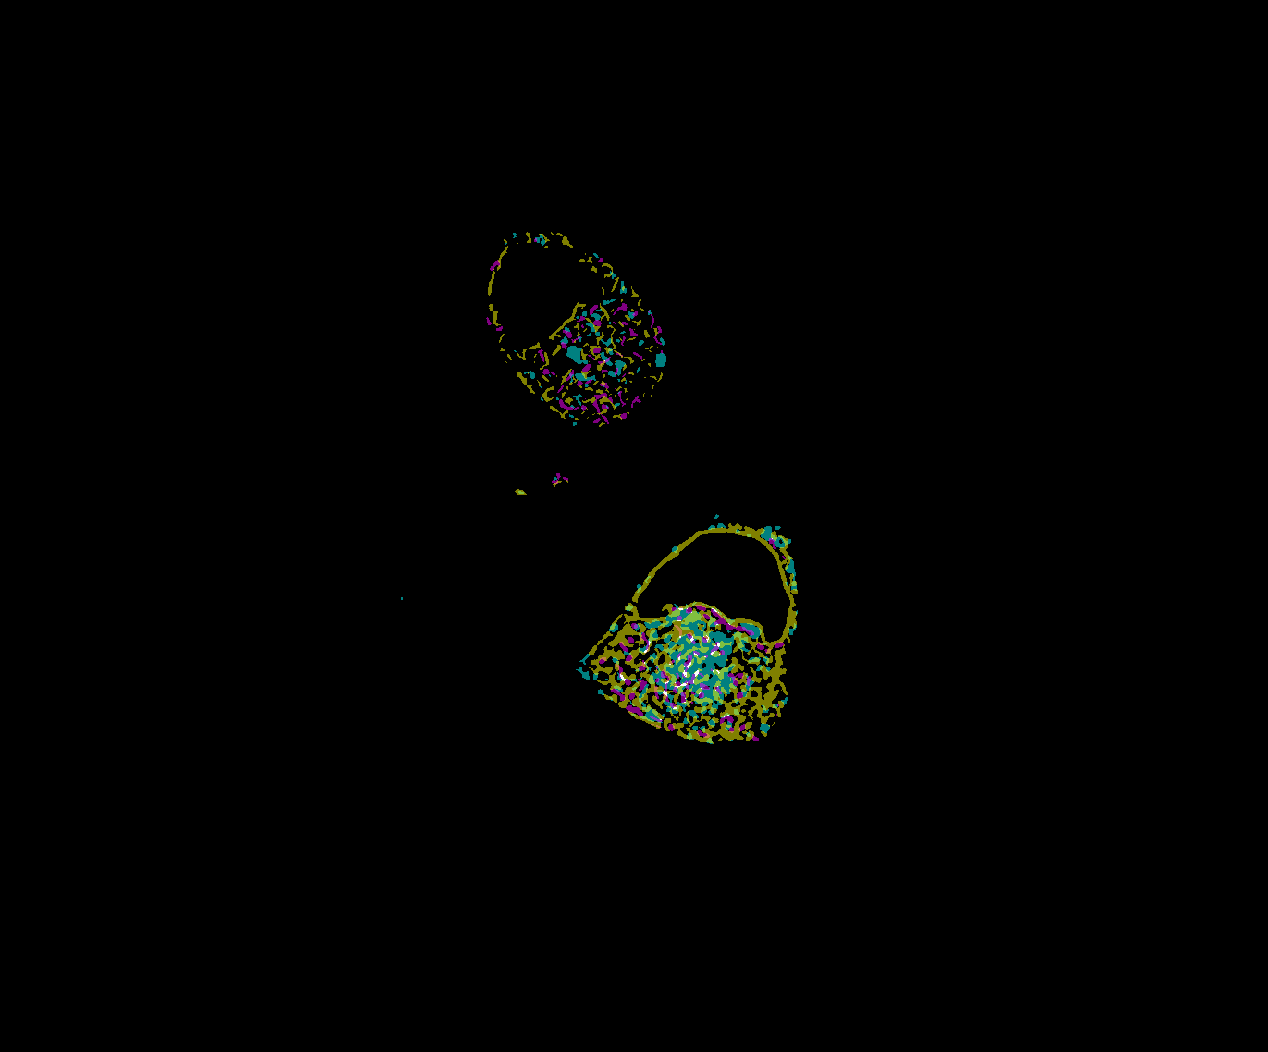

In [19]:
viewer = napari.Viewer()
colors=['cyan', 'magenta', 'yellow', 'green', 'red', 'blue'] #currently enough colors to visualize 6 orgs
for color, org in enumerate(orgs.split(splitter)): 
    viewer.add_labels(organelle_segs[org]>0, color={1: colors[color]}, 
                      blending='translucent', opacity=0.5, scale=scale)
viewer.add_labels(site>0, color={1: 'white'}, blending='translucent', opacity=1.00, scale=scale)

nbscreenshot(viewer, canvas_only=True)

In [20]:
viewer.close()

## **`4` - Determine which nth order interactions are present in n+1 order interactions**

- adjust previous method for finding higher order contacts to work with nth order

In [21]:
LOc_NR = site.copy()                         
for org, val in organelle_segs.items():         
    if (org not in orgs.split(splitter)         #Proceeds if the organelle is not any of the orgs in nth order
        and np.any(overlap*val)):               
        digit = len(str(np.max(val)))           
        valid = (LOc_NR>0)*(val>0)              
        HOc = (LOc_NR*(10**(digit)))+val        
        HOc[valid.astype(bool)==False]=0        
        HOc = label(HOc)                        
        for id in np.unique(site[HOc > 0]):   
            LOc_NR[LOc_NR==id] = 0              

- visualize segmentations 'a', 'b', and 'c', their interactions, and their interactions present in higher order interactions

c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\napari\components\viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,
c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\napari\components\viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,
c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\napari\components\viewer_model.py:10: FutureWarning: Labels.color is deprecated since 0.4.19 and will be removed in 0.5.0, please set Labels.colormap directly with an instance of napari.utils.colormaps.DirectLabelColormap instead.
  TYPE_CHECKING,
c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\napari\compo

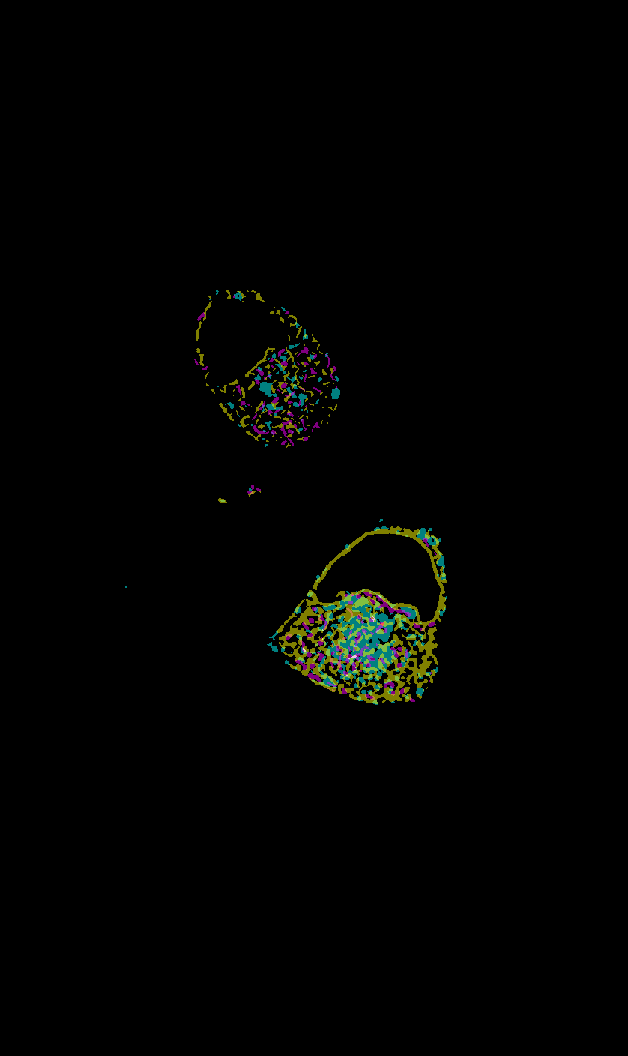

In [22]:
viewer = napari.Viewer()
colors=['cyan', 'magenta', 'yellow', 'green', 'red', 'blue'] #currently enough colors to visualize 6 orgs
for color, org in enumerate(orgs.split(splitter)): 
    viewer.add_labels(organelle_segs[org]>0, color={1: colors[color]}, 
                      blending='translucent', opacity=0.5, scale=scale)
viewer.add_labels(LOc_NR>0, color={1: 'white'}, blending='translucent', opacity=1.00, scale=scale)
viewer.add_labels(LOc_NR, scale=scale)
viewer.add_labels(site, scale=scale)
nbscreenshot(viewer, canvas_only=True)

In [23]:
viewer.close()

In [24]:
site = label(apply_mask(site, mask_img)).astype(int)
LOc_NR = apply_mask((LOc_NR>0), mask_img).astype(int) * site

## **`5` - Build the list of measurements we want to include from regionprops and run regionprops**

- assemble list of measurements (morphological properties)

In [25]:
# start with LABEL
test_Xproperties = ["label"]

# add position
test_Xproperties = test_Xproperties + ["centroid", "bbox"]

# add area
test_Xproperties = test_Xproperties + ["area", "equivalent_diameter"] # "num_pixels", 

# add shape measurements - NOTE: can't include minor axis measure because some of the contact sites are only one pixel
test_Xproperties = test_Xproperties + ["extent", "euler_number", "solidity", "axis_major_length", "slice"] # "feret_diameter_max",  , "axis_minor_length"

- create initial regionprops table

In [26]:
## NOTE: it may be worth our time to deal with the measurements that having issues with one voxel objects: 
## axis_min_length - the minimum axis of a voxel should be calulated as the minimum axis of a elipsoid with the same central moment as the voxel;
## when scaling this number should be calculated, but without scale, I think this would just be ~1

test_Xprops = regionprops_table(site, 
                                intensity_image=None, 
                                properties=test_Xproperties, 
                                extra_properties=None, 
                                spacing=scale)

c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 884472094  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

  return convex_hull_image(self.image)
c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:629: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options se

In [27]:
test_Xsurface_area_tab = pd.DataFrame(surface_area_from_props(site, test_Xprops, scale=scale))

## **`3` - Track which individual organelles are involved in that interaction**

- identify labels involved in each unique interaction

In [28]:
cont_inv = []
involved = orgs.split(splitter)
indexes = dict.fromkeys(involved, [])
indexes[orgs] = []

redundancy = []
for index, l in enumerate(test_Xprops["label"]):
    cont_inv.clear()
    present = LOc_NR[test_Xprops["slice"][index]]
    present = present==l
    redundant = not np.any(present)
    redundancy.append(redundant)
    for org in involved:
        volume = site[test_Xprops["slice"][index]]
        lorg = organelle_segs[org][test_Xprops["slice"][index]]
        volume = volume==l
        lorg = lorg[volume]                                 
        all_inv = np.unique(lorg[lorg>0]).tolist()          
        if len(all_inv) != 1:
            print(f"we have an error.  as-> {all_inv}")
        indexes[org].append(all_inv[0])
        cont_inv.append(f"{all_inv[0]}")
    indexes[orgs].append('_'.join(cont_inv))

- correct and add measurements

In [29]:
props_table = pd.DataFrame(test_Xprops)
props_table.drop(columns=['slice', 'label'], inplace=True)
props_table.insert(0, 'label',value=indexes[orgs])
props_table.insert(0, "object", orgs)
props_table.rename(columns={"area": "volume"}, inplace=True)
props_table.insert(11, "surface_area", test_Xsurface_area_tab)
props_table.insert(13, "SA_to_volume_ratio", 
props_table["surface_area"].div(props_table["volume"]))
if scale is not None:
    round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
    props_table.insert(loc=2, column="scale", value=f"{round_scale}")
else: 
    props_table.insert(loc=2, column="scale", value=f"{tuple(np.ones(site.ndim))}")
props_table.insert(2, "in_higher_order", list(map(bool, redundancy)))

In [30]:
props_table.head()

,object,label,in_higher_order,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,...,bbox-4,bbox-5,surface_area,volume,SA_to_volume_ratio,equivalent_diameter,extent,euler_number,solidity,axis_major_length
0,lysoXmitoXER,19_26_1,False,"(0.3891, 0.0706, 0.0706)",1.121030,35.708520,32.923286,2,503,463,...,509,470,2.062616,0.081552,25.292189,0.538036,0.333333,1,0.700000,1.233469
1,lysoXmitoXER,50_62_1,False,"(0.3891, 0.0706, 0.0706)",0.778236,38.039640,32.600360,2,538,461,...,540,463,0.313535,0.003883,80.737133,0.195017,0.500000,1,inf,0.223383
2,lysoXmitoXER,50_63_1,False,"(0.3891, 0.0706, 0.0706)",0.778236,38.251560,31.505440,2,541,446,...,543,447,0.268514,0.003883,69.143895,0.195017,1.000000,1,inf,0.157956
3,lysoXmitoXER,22_28_1,True,"(0.3891, 0.0706, 0.0706)",0.817148,38.399904,36.640968,2,542,517,...,546,521,0.822918,0.019417,42.381270,0.333474,0.312500,1,0.769231,0.553189
4,lysoXmitoXER,56_32_1,False,"(0.3891, 0.0706, 0.0706)",1.184272,40.333904,33.772063,2,567,473,...,577,485,4.052608,0.178637,22.686319,0.698753,0.255556,1,0.516854,1.208460


<!-- #### `WIP`: Adding a "SHELL" measurement for each site of interaction, we want to measure the membrane surface area from each organelle involved in the interaction

I think the most logical way to do this seems to be using marching_cubes to create an isosurface of each object (org A, org B, and the intersection), then cut the orgs' isosurface using the overlap region. The isosurface region of intersection between the org and the overlap will be measured as the membrane in the interaction.

- **shell_aXb**: the "shell", or membrane, of organelle a overlapping with organelle b (*NOTE: shell_aXb and shellbXa are *NOT* redundant*) -->

# ***EXECUTE FUNCTION PROTOTYPE***

## **Define `_make_dict` function**

In [31]:
def _make_dict(list_obj_names: list[str],
               list_obj_segs: list[np.ndarray]):
    organelle_segs = {}                                                     
    for idx, name in enumerate(list_obj_names):                                  
        if name == 'ER':                                                    
            organelle_segs[name]=(list_obj_segs[idx]>0).astype(np.uint16)        
        else:                                                       
            organelle_segs[name]=list_obj_segs[idx]
    return organelle_segs

## **Define `_all_combo` function**

In [32]:
def _all_combo(list_obj_names: list[str], splitter: str="X"):
    all_pos = []
    for n in list(map(lambda x:x+2, (range(len(list_obj_names)-1)))):
        all_pos += itertools.combinations(list_obj_names, n)
    possib = [splitter.join(cont) for cont in all_pos]
    return possib

## **Define `_create_contact` function**

In [33]:
def _create_contact(orgs:str,
                    organelle_segs: dict[str:np.ndarray],
                    splitter: str="X") -> tuple[np.ndarray, np.ndarray]: 
    ##########################################
    ## CREATE CONTACT
    ##########################################
    site = np.ones_like(organelle_segs[orgs.split(splitter)[0]])
    for org in orgs.split(splitter):
        b = organelle_segs[org]             
        valid = (b>0)*(site>0)
        digit = len(str(np.max(site)))      
        site = (b*(10**(digit)))+site       
        site[valid.astype(bool)==False]=0   
        site = label(site)             
        
             
    ##########################################
    ## DETERMINE REDUNDANT CONTACTS
    ##########################################
    LOc_NR = site.copy()                         
    for org, val in organelle_segs.items():         
        if (org not in orgs.split(splitter)
            and np.any(site*val)):
            print(f"Examining {orgs} Higher Order Contacts With {org}...", end="\r")               
            digit = len(str(np.max(val)))           
            valid = (LOc_NR>0)*(val>0)              
            HOc = (LOc_NR*(10**(digit)))+val        
            HOc[valid.astype(bool)==False]=0        
            HOc = label(HOc) 
            maxi = len(np.unique(LOc_NR[HOc>0]))                       
            for num, id in enumerate(np.unique(site[HOc > 0])):
                per = round((100*((num+1)/maxi)), 2)   
                LOc_NR[LOc_NR==id] = 0
                print(f"Examining {orgs} Higher Order Contacts With {org}: {per}% complete", end="\r")
            print(f"Examining {orgs} Higher Order Contacts With {org}: {per}% complete")     
    return site, LOc_NR

## **Define `_contact_metric_analysis` function**

In [34]:
def _contact_metric_analysis(contact_ID: str,
                             org_dict: dict,
                             mask: np.ndarray,
                             splitter: str="X",
                             scale: Union[tuple, None]=None,
                             include_dist:bool=False, 
                             dist_centering_obj: Union[np.ndarray, None]=None,
                             dist_num_bins: Union[int, None]=None,
                             dist_zernike_degrees: Union[int, None]=None,
                             dist_center_on: Union[bool, None]=None,
                             dist_keep_center_as_bin: Union[bool, None]=None):
    """
    collect volumentric measurements of intersection between n organelle types

    Parameters
    ------------
    contact_ID: str
        a value used to describe the organelles present in the overlap that can be divided by the splitter value
    org_dict: dict
        a dictionary of all object segmentations assigned to keys with their objects
    mask: np.ndarray
        3D (ZYX) binary mask of the area to measure contacts from
    splitter: str
        a value used to separate the contact_ID to determine objects present in overlap
    scale: tuple
        a value present in the metadata determining the scale of the (ZYX) axis
    include_dist:bool=False
        *optional*
        True = include the XY and Z distribution measurements of the contact sites within the masked region 
        (utilizing the functions get_XY_distribution() and get_Z_distribution() from Infer-subc)
        False = do not include distirbution measurements
    dist_centering_obj: Union[np.ndarray, None]=None
        ONLY NEEDED IF include_dist=True; if None, the center of the mask will be used
        3D (ZYX) np.ndarray containing the object to use for centering the XY distribution mask
    dist_num_bins: Union[int, None]=None
        ONLY NEEDED IF include_dist=True; if None, the default is 5
    dist_zernike_degrees: Unions[int, None]=None,
        ONLY NEEDED IF include_dist=True; if None, the zernike share measurements will not be included in the distribution
        the number of zernike degrees to include for the zernike shape descriptors
    dist_center_on: Union[bool, None]=None
        ONLY NEEDED IF include_dist=True; if None, the default is False
        True = distribute the bins from the center of the centering object
        False = distribute the bins from the edge of the centering object
    dist_keep_center_as_bin: Union[bool, None]=None
        ONLY NEEDED IF include_dist=True; if None, the default is True
        True = include the centering object area when creating the bins
        False = do not include the centering object area when creating the bins


    Regionprops measurements:
    ------------------------
    ['label',
    'centroid',
    'bbox',
    'area',
    'equivalent_diameter',
    'extent',
    'feret_diameter_max',
    'euler_number',
    'convex_area',
    'solidity',
    'axis_major_length',
    'axis_minor_length']

    Additional measurements:
    ----------------------
    ['surface_area']

    
    Returns
    -------------
    pandas dataframe of containing regionprops measurements (columns) for each overlap region (rows)
    
    """
    #########################
    ## CREATE OVERLAP REGIONS
    #########################
    # run create contact function
    site, LOc_NR = _create_contact(contact_ID, org_dict, splitter)

    #assert the nth order contact to within the cellmask
    labels = label(apply_mask(site, mask)).astype(int)

    #assert the nth order contacts present in n+1 order contacts to within the cellmask
    para_labels = apply_mask((LOc_NR>0), mask).astype(int) * labels


    ##########################################
    ## CREATE LIST OF REGIONPROPS MEASUREMENTS
    ##########################################
    # start with LABEL
    properties = ["label"]

    # add position
    properties += ["centroid", "bbox"]

    # add area
    properties += ["area", "equivalent_diameter"] # "num_pixels", 

    # add shape measurements - NOTE: can't include minor axis measure because some of the contact sites are only one pixel
    properties += ["extent", "euler_number", "solidity", "axis_major_length", "slice"] # "feret_diameter_max",  , "axis_minor_length"
    

    ##################
    ## RUN REGIONPROPS
    ##################
    props = regionprops_table(labels, 
                              intensity_image=None, 
                              properties=properties, 
                              extra_properties=None, 
                              spacing=scale)

    ##################################################################
    ## RUN SURFACE AREA FUNCTION SEPARATELY AND APPEND THE PROPS_TABLE
    ##################################################################
    surface_area_tab = pd.DataFrame(surface_area_from_props(labels, props, scale))

    ####################################################
    ## LIST WHICH ORGANELLES ARE INVOLVED IN THE CONTACT
    ####################################################
    cont_inv = []
    involved = contact_ID.split(splitter)
    indexes = dict.fromkeys(involved, [])
    indexes[contact_ID] = []

    redundancy = []
    for index, l in enumerate(props["label"]):
        cont_inv.clear()
        present = para_labels[props["slice"][index]]
        present = present==l
        redundant = not np.any(present)
        redundancy.append(redundant)
        for org in involved:
            volume = labels[props["slice"][index]]
            lorg = org_dict[org][props["slice"][index]]
            volume = volume==l
            lorg = lorg[volume]                                 
            all_inv = np.unique(lorg[lorg>0]).tolist()          
            if len(all_inv) != 1:
                print(f"we have an error.  as-> {all_inv}")
            indexes[org].append(all_inv[0])
            cont_inv.append(f"{all_inv[0]}")
        indexes[contact_ID].append('_'.join(cont_inv))

        
    ##################################################
    ## CREATE COMBINED DATAFRAME OF THE QUANTIFICATION
    ##################################################
    props_table = pd.DataFrame(props)
    props_table.drop(columns=['slice', 'label'], inplace=True)
    props_table.insert(0, 'label',value=indexes[contact_ID])
    props_table.insert(0, "object", contact_ID)
    props_table.rename(columns={"area": "volume"}, inplace=True)
    props_table.insert(11, "surface_area", surface_area_tab)
    props_table.insert(13, "SA_to_volume_ratio", 
    props_table["surface_area"].div(props_table["volume"]))
    if scale is not None:
        round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
        props_table.insert(loc=2, column="scale", value=f"{round_scale}")
    else: 
        props_table.insert(loc=2, column="scale", value=f"{tuple(np.ones(labels.ndim))}")
    props_table.insert(2, "in_higher_order", list(map(bool, redundancy)))


    ######################################################
    ## optional: DISTRIBUTION OF CONTACTS MEASUREMENTS
    ######################################################
    if include_dist:
        XY_contact_dist, XY_bins, XY_wedges = get_XY_distribution(mask=mask, 
                                                                  obj=site,
                                                                  obj_name=contact_ID,
                                                                  centering_obj=dist_centering_obj,
                                                                  scale=scale,
                                                                  center_on=dist_center_on,
                                                                  keep_center_as_bin=dist_keep_center_as_bin,
                                                                  num_bins=dist_num_bins,
                                                                  zernike_degrees=dist_zernike_degrees)
        
        Z_contact_dist = get_Z_distribution(mask=mask,
                                            obj=site,
                                            obj_name=contact_ID,
                                            center_obj=dist_centering_obj,
                                            scale=scale)
        contact_dist_tab = pd.merge(XY_contact_dist, Z_contact_dist, on=["object", "scale"])

        indexes.clear()
        return props_table, contact_dist_tab
    else:
        indexes.clear()
        return props_table

## **Define `_get_contact_metrics_3D` function**

Based on the _prototyping_ above define the function to quantify amount, size, and shape of organelles.

In [35]:
def _get_contact_metrics_3D(list_obj_names: list[str],
                            list_obj_segs: list[np.ndarray],
                            mask: np.ndarray,
                            splitter: str="X",
                            scale: Union[tuple, None]=None,
                            include_dist:bool=False, 
                            dist_centering_obj: Union[np.ndarray, None]=None,
                            dist_num_bins: Union[int, None]=None,
                            dist_zernike_degrees: Union[int, None]=None,
                            dist_center_on: Union[bool, None]=None,
                            dist_keep_center_as_bin: Union[bool, None]=None):
    """
    collect volumentric measurements of intersection between n, n+1, n+2... organelle types for an entire cell

    Parameters
    ------------
    list_obj_names: list
        a list of the names of objects used in making contacts
    list_obj_segs: list
        a list of the segmentations of the objects used in making contacts
    mask: np.ndarray
        3D (ZYX) binary mask of the area to measure contacts from
    splitter: str="X"
        a value used to separate the organelles in their IDs
    scale: tuple
        3D (ZYX) assignment for the scaling of each axis
        include_dist:bool=False
        *optional*
        True = include the XY and Z distribution measurements of the contact sites within the masked region 
        (utilizing the functions get_XY_distribution() and get_Z_distribution() from Infer-subc)
        False = do not include distirbution measurements
    dist_centering_obj: Union[np.ndarray, None]=None
        ONLY NEEDED IF include_dist=True; if None, the center of the mask will be used
        3D (ZYX) np.ndarray containing the object to use for centering the XY distribution mask
    dist_num_bins: Union[int, None]=None
        ONLY NEEDED IF include_dist=True; if None, the default is 5
    dist_zernike_degrees: Unions[int, None]=None,
        ONLY NEEDED IF include_dist=True; if None, the zernike share measurements will not be included in the distribution
        the number of zernike degrees to include for the zernike shape descriptors
    dist_center_on: Union[bool, None]=None
        ONLY NEEDED IF include_dist=True; if None, the default is False
        True = distribute the bins from the center of the centering object
        False = distribute the bins from the edge of the centering object
    dist_keep_center_as_bin: Union[bool, None]=None
        ONLY NEEDED IF include_dist=True; if None, the default is True
        True = include the centering object area when creating the bins
        False = do not include the centering object area when creating the bins

    Regionprops measurements:
    ------------------------
    ['label',
    'centroid',
    'bbox',
    'area',
    'equivalent_diameter',
    'extent',
    'feret_diameter_max',
    'euler_number',
    'convex_area',
    'solidity',
    'axis_major_length',
    'axis_minor_length']

    Additional measurements:
    ----------------------
    ['surface_area']

    
    Returns
    -------------
    pandas dataframe of containing regionprops measurements (columns) for each overlap region (rows)
    """

    ########################
    ## CREATE ORGANELLE DICT
    ########################
    organelle_segs = _make_dict(list_obj_names, list_obj_segs)                                                 
    
    #########################
    ## LIST POSSIBLE OVERLAPS
    #########################
    possib = _all_combo(list_obj_names, splitter)

    #######################
    ## ANALYZE ALL OVERLAPS
    #######################
    cont_tabs=[]
    dist_tabs=[]
    if include_dist:
        for cont in possib:
            cont_tab, dist_tab = _contact_metric_analysis(contact_ID=cont,
                                                          org_dict=organelle_segs,
                                                          mask=mask,
                                                          splitter=splitter,
                                                          scale=scale,
                                                          include_dist=True,
                                                          dist_centering_obj=dist_centering_obj,
                                                          dist_num_bins=dist_num_bins,
                                                          dist_zernike_degrees=dist_zernike_degrees,
                                                          dist_center_on=dist_center_on,
                                                          dist_keep_center_as_bin=dist_keep_center_as_bin)
            cont_tabs.append(cont_tab)
            dist_tabs.append(dist_tab)
        cont_tables = pd.concat(cont_tabs)
        dist_tables = pd.concat(dist_tabs)
        return cont_tables, dist_tables
    else:
        for cont in possib:
            cont_tab = _contact_metric_analysis(contact_ID=cont,
                                                org_dict=organelle_segs,
                                                mask=mask,
                                                splitter=splitter,
                                                scale=scale,
                                                include_dist=False)
        cont_tables = pd.concat(cont_tabs)
        return cont_tables

## **Run `_get_contact_metrics_3D` function (scaled)**

In [36]:
stat_tab_test, test_cont_dist_tab = _contact_metric_analysis(contact_ID=orgs, 
                                                             org_dict=organelle_segs,
                                                             mask=region_segs[region_names.index("cell")], 
                                                             scale=scale,
                                                             include_dist=True, 
                                                             dist_centering_obj=region_segs[region_names.index("nuc")],
                                                             dist_center_on=False,
                                                             dist_keep_center_as_bin=True,
                                                             dist_num_bins=5,
                                                             dist_zernike_degrees=9)

stat_tab_test.equals(props_table)

Examining lysoXmitoXER Higher Order Contacts With golgi: 100.0% complete
Examining lysoXmitoXER Higher Order Contacts With perox: 100.0% complete
Examining lysoXmitoXER Higher Order Contacts With LD: 100.0% complete


c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 884640164  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

  return convex_hull_image(self.image)
c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:629: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options se

True

In [37]:
test_cont_dist_tab

,object,scale,XY_n_bins,XY_bins,XY_mask_vox_cnt_perbin,XY_obj_vox_cnt_perbin,XY_center_vox_cnt_perbin,XY_n_pix_perbin,XY_portion_pix_perbin,XY_n_wedges,...,zernike_center_phs,Z_n_slices,Z_slices,Z_mask_vox_cnt,Z_obj_vox_cnt,Z_center_vox_cnt,Z_height,Z_mask_volume,Z_obj_volume,Z_center_volume
0,lysoXmitoXER,"(0.3891, 0.0706, 0.0706)",5,"[1, 2, 3, 4, 5]","[463339, 136036, 200670, 222982, 260487]","[757, 1003, 1728, 965, 392]","[328716, 0, 0, 0, 0]","[17429.0, 4641.0, 7007.0, 9308.0, 36673.0]","[0.23220709318127314, 0.06183218311172693, 0.0...",8,...,"[1.5707963267948966, 0.25169575920875076, -1.5...",35,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[10178, 14456, 17745, 24357, 30765, 36439, 416...","[0, 0, 46, 180, 265, 177, 229, 175, 229, 229, ...","[0, 0, 392, 2255, 4202, 5270, 6723, 8210, 9352...",13.61913,"[19.76264861021284, 28.069252142782155, 34.455...","[0.0, 0.0, 0.0893183175545088, 0.3495064599959...","[0.0, 0.0, 0.7611474017688575, 4.3785392627264..."


## **Compare to finalized `get_contact_metrics_3D` function**

In [39]:
from infer_subc.utils.stats import contact_metric_analysis

test_stat_tab_final, test_cont_dist_tab_final = contact_metric_analysis(contact_ID=orgs, 
                                                             org_dict=organelle_segs,
                                                             mask=region_segs[region_names.index("cell")], 
                                                             scale=scale,
                                                             include_dist=True, 
                                                             dist_centering_obj=region_segs[region_names.index("nuc")],
                                                             dist_center_on=False,
                                                             dist_keep_center_as_bin=True,
                                                             dist_num_bins=5,
                                                             dist_zernike_degrees=9)

stat_tab_test.equals(test_stat_tab_final), test_cont_dist_tab.equals(test_cont_dist_tab_final)

Examining lysoXmitoXER Higher Order Contacts With golgi: 100.0% complete
Examining lysoXmitoXER Higher Order Contacts With perox: 100.0% complete
Examining lysoXmitoXER Higher Order Contacts With LD: 100.0% complete


c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 885396479  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

  return convex_hull_image(self.image)
c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:629: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
c:\Users\zscoman\Anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options se

(True, True)